In [25]:
import sys; sys.path.append("../../wwa"); from wwa import *

mapproj = cartopy.crs.AlbersEqualArea(central_longitude = 1.0, central_latitude = 47.0)

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/"

Xn,Xx,Yn,Yx = [0,35,55,75]
xn,xx,yn,yx = [4,30,60,72]

sf = gpd.read_file("sf_fennoscandia")

# Shapefile for study region

In [ ]:
sf = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("names").loc[["Sweden", "Norway", "Finland"]]
sf = main_polygon(sf.dissolve())
sf.to_file("sf_fennoscandia")

# Get gridded obs 

## ERA5

In [29]:
# ! wget https://climexp.knmi.nl/data/era5_tmax_daily_eu_extended_0-40E_40-75N_-999-lastyear_su.nc -O $fpath/era5-tmax-daily_0-40E_40-75N.nc
# ! wget https://climexp.knmi.nl/data/era5_tmin_daily_eu_extended_0-40E_40-75N_-999-lastyear_su.nc -O $fpath/era5-tmin-daily_0-40E_40-75N.nc

--2025-08-09 10:15:47--  https://climexp.knmi.nl/data/era5_tmax_daily_eu_extended_0-40E_40-75N_-999-lastyear_su.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1705228938 (1.6G) [application/x-netcdf]
Saving to: ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat//era5-tmax-daily_0-40E_40-75N.nc’

/rds/general/user/c 100%[===================>]   1.59G  48.2MB/s    in 27s     

2025-08-09 10:16:14 (60.5 MB/s) - ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat//era5-tmax-daily_0-40E_40-75N.nc’ saved [1705228938/1705228938]

--2025-08-09 10:16:14--  https://climexp.knmi.nl/data/era5_tmin_daily_eu_extended_0-40E_40-75N_-999-lastyear_su.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (c

In [ ]:
lsm = xr.open_dataset(fpath+"era5_000000_lsm_eu.nc").lsm.squeeze(drop = True).rename(latitude = "lat", longitude = "lon")

In [ ]:
for varnm in ["tmin", "tmax"]:
    da = xr.open_dataset(fpath+"era5-"+varnm+"-daily_eu_extended_0-35E_55-75N_-999-lastyear.nc")[varnm]

    da = da.where(lsm.sel(lon = da.lon, lat = da.lat) >= 0.5, drop = True)
    da.to_netcdf("data/era5_"+varnm+"_daily_land_0-35E_55-75N.nc")

# Wider region for plotting purposes

In [2]:
for varnm in ["tmin", "tmax"]:
    da = xr.open_dataset("data/era5-"+varnm+"-daily_0-40E_40-75N.nc")[varnm].sel(lat = slice(None,50))
    rm = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(da)
    da = da.where(rm == 0, drop = True)
    da.to_netcdf(fpath+"era5_"+varnm+"_daily_land_0-40E_50-75N.nc")

## E-Obs

In [ ]:
# lower-res data from Climate Explorer
! cd $fpath; wget https://climexp.knmi.nl/data/tx_0.25deg_reg_v31.0eu_0-35E_55-71.88N_firstyear-lastyear.nc
! cd $fpath; wget https://climexp.knmi.nl/data/tn_0.25deg_reg_v31.0eu_0-35E_55-71.88N_-999-lastyear.nc

### Retrieve latest from Copernicus (both resolutions for now, in case of gaps)

In [ ]:
! cd $fpath; wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/Grid_0.1deg_reg_ensemble/tx_ens_mean_0.1deg_reg_v31.0e.nc
! cd $fpath; wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/Grid_0.1deg_reg_ensemble/tn_ens_mean_0.1deg_reg_v31.0e.nc

In [ ]:
# historic data
! cd $fpath; wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/Grid_0.25deg_reg_ensemble/tx_ens_mean_0.25deg_reg_v31.0e.nc
! cd $fpath; wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/Grid_0.25deg_reg_ensemble/tn_ens_mean_0.25deg_reg_v31.0e.nc

In [ ]:
! cd $fpath; wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/months/ens/tx_0.25deg_day_2025_grid_ensmean.nc
! cd $fpath; wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/months/ens/tn_0.25deg_day_2025_grid_ensmean.nc

### Extract wider region

In [2]:
varnm = "tn"
res = "0.25"

In [ ]:
ds_2025 = xr.open_dataset(fpath+varnm+"_"+res+"deg_day_2025_grid_ensmean.nc").dropna("time", "all").sel(longitude = slice(Xn,Xx), latitude = slice(Yn,Yx))

In [ ]:
ds_hist = xr.open_dataset(fpath+varnm+"_ens_mean_"+res+"deg_reg_v31.0e.nc").dropna("time", "all").sel(longitude = slice(Xn,Xx), latitude = slice(Yn,Yx))

In [ ]:
ds = xr.merge([ds_hist, ds_2025], "time")

In [ ]:
ds = xr.open_mfdataset([fnm for fnm in glob.glob(fpath+varnm+"*"+res+"*.nc") if not "lastyear" in fnm])
ds = ds[list(ds.data_vars)[0]].sel(longitude = slice(Xn,Xx), latitude = slice(Yn,Yx))
ds = ds.dropna("time", "all")

In [ ]:
ds.to_netcdf(fpath+"eobs_"+varnm+"_"+res+"deg.nc")

## CPC

In [26]:
! cd $fpath; wget https://climexp.knmi.nl/data/tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc -O tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc
! cd $fpath; wget https://climexp.knmi.nl/data/tmin_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc -O tmin_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc

--2025-08-11 10:00:03--  https://climexp.knmi.nl/data/tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92157433 (88M) [application/x-netcdf]
Saving to: ‘tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc’

tmax_cpc_daily_0-35 100%[===================>]  87.89M   148MB/s    in 0.6s    

2025-08-11 10:00:04 (148 MB/s) - ‘tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc’ saved [92157433/92157433]

--2025-08-11 10:00:04--  https://climexp.knmi.nl/data/tmin_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93413016 (89M) [application

## MSWX

In [2]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/mswx_fs/"

In [ ]:
for y in range(2025,1978,-1):

    print(y)
    new_fnm = outpath+"tmax_mswx_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
        
    ds = xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/Tmax/"+str(y)+"/*.nc")
    ds = ds.sel(lon = slice(Xn,Xx), lat = slice(Yx,Yn)).rename(air_temperature = "tmax")
    ds.to_netcdf(new_fnm)

In [ ]:
# compile & save
wrap_lon(xr.open_mfdataset(outpath+"*.nc")).to_netcdf("data/tmax_mswx.nc")

# Climate model data

## CMIP6

In [4]:
varnm = "tasmax"
fl = sorted(glob.glob("data/cmip6/"+varnm+"_day_*"))
for fnm in fl:

    print(fnm)
    if os.path.exists(re.sub(varnm, varnm+"-sc", fnm)): continue
    
    da = convert_units_to(xr.open_dataset(fnm)[varnm], "degC")

    if "height" in da.coords: da = da.reset_coords("height", drop = True)

    # spatial patterns for evaluation
    da_sp = da.sel(time = slice("1990","2020")).groupby("time.month").mean()
    da_sp.to_netcdf(re.sub(varnm, varnm+"-sp", fnm[:-21]+".nc"))
    
    # daily timeseries over study region
    rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
    ts = da.where(rm == 0, drop = True).mean(["lat", "lon"])
    ts.to_netcdf(re.sub(varnm, varnm+"-fs", fnm))
    
    # seasonal cycle for evaluation
    sc = ts.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
    sc.to_netcdf(re.sub(varnm, varnm+"-sc", fnm[:-21]+".nc"))
    
clear_output(wait = False)
print("Done.")

Done.


## CORDEX

In [ ]:
varnm = "tasmin"
fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/"+varnm+"_EUR-11_*"))

for fnm in fl:

    print(fnm)
#     if os.path.exists("data/cordex/"+re.sub(varnm, varnm+"-sc", fnm.split("/")[-1][:-21]+".nc")): continue
        
    if fnm in ["/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CanESM2_r1i1p1_CCLM4-8-17_19500101-20501231.nc",
               "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CanESM2_r1i1p1_REMO2015_19500102-20501231.nc",
               "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_EC-EARTH_r12i1p1_CCLM4-8-17_19491201-20501231.nc"]:
        continue
    
    da = xr.open_dataset(fnm)
    if "height" in da.coords: da = da.reset_coords("height", drop = True)
    if "longitude" in da.data_vars: da = da.rename(longitude = "lon", latitude = "lat")
    rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
    
    if "lon" in da.data_vars: da = da.assign_coords(lon = da.lon, lat = da.lat)
    
    if "x" in da.dims:
        xdim,ydim = ["x", "y"]
    elif "rlat" in da.dims:
        xdim,ydim = ["rlon", "rlat"]

    # spatial patterns for evaluation
    da_sp = da.sel(time = slice("1990","2020")).groupby("time.month").mean()
    da_sp.to_netcdf("data/cordex/"+re.sub(varnm, varnm+"-sp", fnm.split("/")[-1][:-21]+".nc"))
    
#     da = convert_units_to(da[varnm], "degC")

#     # daily timeseries over study region
#     ts = da.where(rm == 0, drop = True).mean([xdim, ydim])
#     ts.to_netcdf("data/cordex/"+re.sub(varnm, varnm+"-fs", fnm.split("/")[-1]))

#     # seasonal cycle for evaluation
#     sc = ts.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
#     sc.to_netcdf("data/cordex/"+re.sub(varnm, varnm+"-sc", fnm.split("/")[-1][:-21]+".nc"))
clear_output(wait = False)
print("Done.")

/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CNRM-CM5_r1i1p1_ALADIN53_19500101-20501231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CNRM-CM5_r1i1p1_ALADIN63_19510101-20501231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CNRM-CM5_r1i1p1_CCLM4-8-17_19500101-20501231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CNRM-CM5_r1i1p1_HIRHAM5_19510101-20501231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CNRM-CM5_r1i1p1_HadREM3-GA7-05_19511201-20501231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CNRM-CM5_r1i1p1_RACMO22E_19500101-20501231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/cordex/tasmin_EUR-11_CNRM-CM5_r1i1p1_RCA4_19700101-20501231.nc
/rds/general/user/cb2714/home/00_WWA_p

# Time series & spatial pattern over study region

In [15]:
sf = gpd.read_file("sf_fennoscandia")

ndays = 14

## Obs products

In [27]:
tx_list = {
           # "era5" : "era5_tmax_daily_land_0-40E_40-75N.nc",
           # "eobs" : "tx_0.25deg_reg_v31.0eu_0-35E_55-71.88N_firstyear-lastyear.nc",
           "cpc" : "tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc"
          }

tn_list = {
           # "era5" : "era5_tmin_daily_land_0-40E_40-75N.nc",
           # "eobs" : "tn_0.25deg_reg_v31.0eu_0-35E_55-71.88N_-999-lastyear.nc",
           "cpc" : "tmin_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc"
          }

In [28]:
for varnm in ["tx", "tn"]:
    vnm = {"tx" : "max", "tn" : "min"}[varnm]

    ds_list = eval(varnm+"_list")
    
    for ds_nm, fnm in ds_list.items():

        print(fnm)
    
        da = wrap_lon(xr.open_dataset(fpath+fnm))
        da = da[list(da.data_vars)[0]]

        if "longitude" in da.dims:
            da = da.rename(longitude = "lon", latitude = "lat")
            

        da_sp = da.sel(time = slice("1990","2020")).groupby("time.month").mean().rename("tas"+vnm)
        da_sp.to_netcdf("data/"+varnm+"-sp_"+ds_nm+".nc")

        rm = regionmask.mask_geopandas(sf, da)

        ts = da.where(rm == 0).mean(["lat", "lon"])
        ts.to_dataframe().to_csv("data/"+varnm+"-fs-daily_"+ds_nm+".csv")

        if ds_nm == "eobs":
            ts = ts.sel(time = slice(None, "2024"))
            
        # create annual time series for Climate Explorer
        txnx = ts.rolling(time = ndays, center = False).mean().resample(time = "AS").max()
        df = txnx.assign_coords(time = txnx.time.dt.year).rename(time = "year").to_dataframe()

        csv_fnm = "fs-heatwave_"+varnm+str(ndays)+"x_"+ds_nm
        csv_fullpath = "ts/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
        # create header lines for upload to Climate Explorer 
        str1 = "# contact :: "+ds_nm.upper()+" "+varnm+str(ndays)+"x over Norway, Sweden and Finland - Fennoscandia heatwave, c.barnes22@imperial.ac.uk"
        str2 = "# "+varnm+str(ndays)+"x [degC] - annual maximum of "+str(ndays)+"-day average of daily "+vnm+"imum temperatures averaged over Norway, Sweden and Finland at "+csv_fnm+".dat"
        head = "# year "+varnm+str(ndays)+"x"

        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc
tmin_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc


## Climate models


In [10]:
framing = "cordex"
varnm = "tasmin"
ndays = 14

vnm = "t"+varnm[-1]+str(ndays)+"x"
fl = glob.glob("data/"+framing+"/"+varnm+"-fs*.nc")
for fnm in fl:

    print(fnm)
    mdl = "_".join(fnm.split("_")[2:-1])

    # create annual time series for Climate Explorer
    ts = xr.open_dataset(fnm)[varnm]
    txnx = ts.rolling(time = ndays, center = False).mean().resample(time = "AS").max()
    df = txnx.assign_coords(time = txnx.time.dt.year).rename(time = "year").to_dataframe()

    csv_fnm = "fs-heatwave_"+vnm+"_"+framing+"_"+mdl
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    framing_l = framing.upper()
    if framing == "cordex": framing_l = framing_l +" EUR-11"
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: "+framing_l+" "+mdl+" "+vnm+" over Norway, Sweden and Finland - Fennoscandia heatwave, c.barnes22@imperial.ac.uk"
    str2 = "# "+vnm+" [degC] - annual maximum of "+str(ndays)+"-day average of daily "+vnm+"imum temperatures averaged over Norway, Sweden and Finland at "+csv_fnm+".dat"
    head = "# year "+vnm

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)
print("Done.")

Done.


# Station data

## Norway

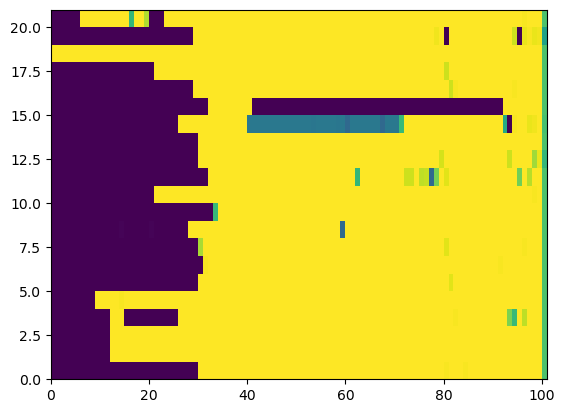

In [3]:
varnm = "tx"

fl = sorted(glob.glob("stations/stations_amalie/"+varnm+"*"))

da_list = [xr.open_dataset(fnm)[varnm] for fnm in fl]
stn_data = pd.DataFrame([da.attrs for da in da_list])
stn_data.to_csv("stations/stations-NO_metadata.csv")

stn_ts = xr.concat([da.expand_dims(stn = [da.station_id]) for da in da_list], "stn")
stn_counts = stn_ts.sel(time = stn_ts.time.dt.month.isin([6,7,8])).resample(time = "AS").count()
plt.pcolormesh(stn_counts)

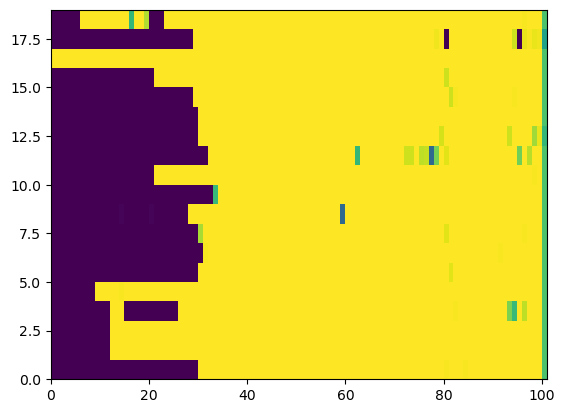

In [4]:
# filter two stations with a lot of missing data
stn_ts = stn_ts.sel(stn = ((stn_counts > 90).sum("time") > 50))
stn_counts = stn_ts.sel(time = stn_ts.time.dt.month.isin([6,7,8])).resample(time = "AS").count()
plt.pcolormesh(stn_counts)

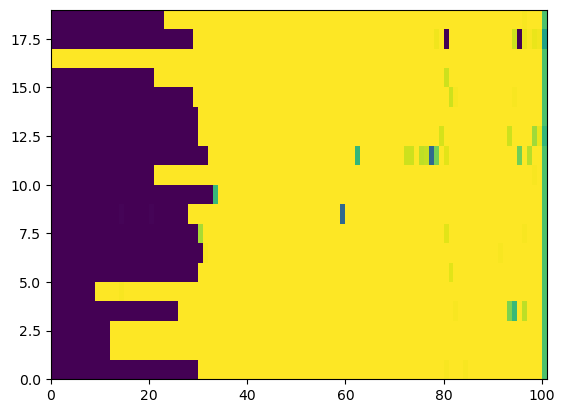

In [5]:
# convert to data.frame (easier to reassign values)
stn_df = stn_ts.to_pandas().transpose()

# truncate to only continuous records
if varnm == "tx":
    stn_df.loc[slice(None, "1947"),["SN98550","SN39100"]] = np.nan

plt.pcolormesh(stn_df.loc[stn_df.index.month.isin([6,7,8])].resample("AS").count().transpose())

In [6]:
# get tx14x & filter to remove years with missing data
nobs = stn_df.loc[stn_df.index.month.isin([6,7,8])].resample("AS").count()
nobs.loc["2025"] = nobs.loc["2025"]+25 # fudge to pick up 2025 as long as all days are available

In [7]:
stn_tx14x = stn_df.rolling(14, center = False).mean().resample("AS").max()
stn_tx14x = stn_tx14x.where(nobs > 90).dropna(axis = 0, how = "all")

<AxesSubplot: xlabel='time'>

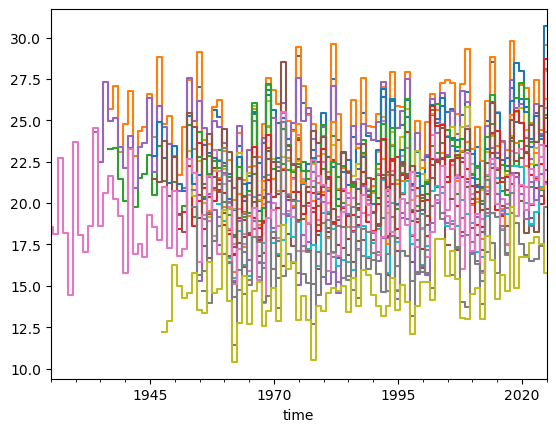

In [8]:
stn_tx14x.plot(drawstyle = "steps-mid", legend = None)

In [9]:
stn_tx14x.index = stn_tx14x.index.year
stn_tx14x.index.name = "year"
stn_tx14x.to_csv("stations/stations-NO_"+varnm+"14x.csv")

## Sweden

In [37]:
df1 = pd.read_excel("stations/stations_other/Haparanda-combined.xlsx", skiprows = 4, index_col = "Representativt dygn", parse_dates = ["Representativt dygn"])
df2 = pd.read_excel("stations/stations_other/Piteå-combined.xlsx", skiprows = 4, index_col = "Representativt dygn", parse_dates = ["Representativt dygn"])

# df1 = df1.rename(columns = {"Lufttemperatur" : "tmin", "Lufttemperatur.1" : "tmax"})[["tmax", "tmin"]]
# df2 = df2.rename(columns = {"Lufttemperatur" : "tmin", "Lufttemperatur.1" : "tmax"})[["tmax", "tmin"]]

In [ ]:
tmin = merge_byindex([df1[["Lufttemperatur"]].rename(columns = {"Lufttemperatur" : "haparanda"}), df2[["Lufttemperatur"]].rename(columns = {"Lufttemperatur" : "pitea"})])
tmax = merge_byindex([df1[["Lufttemperatur.1"]].rename(columns = {"Lufttemperatur.1" : "haparanda"}), df2[["Lufttemperatur.1"]].rename(columns = {"Lufttemperatur.1" : "pitea"})])

In [64]:
tn14x = tmin.rolling(14).mean().resample("AS").max()
tx14x = tmax.rolling(14).mean().resample("AS").max()

tn14x.index = tn14x.index.year
tx14x.index = tx14x.index.year

In [70]:
tx14x.to_csv("stations/stations-SE_tx14x.csv")
tn14x.to_csv("stations/stations-SE_tn14x.csv")

## Finland

In [110]:
df = pd.read_csv("stations/stations_other/Sodankylä Tähtelä_ 1.1.1908 - 7.8.2025.csv", parse_dates = {"Date":["Day","Month","Year"]}, dayfirst = True, index_col = "Date", na_values = "-")
df = df.rename(columns = {"Average temperature [°C]" : "tmean", "Maximum temperature [°C]": "tmax", "Minimum temperature [°C]": "tmin"})

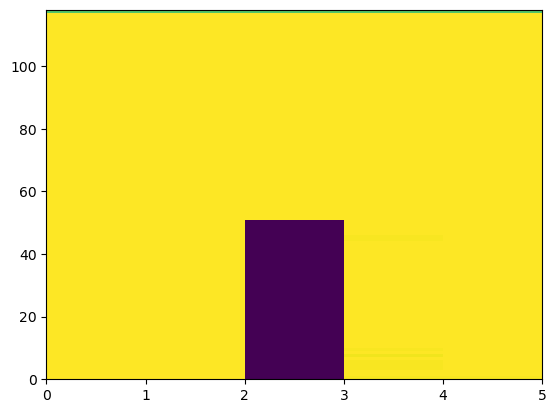

In [111]:
plt.pcolormesh(df.loc[df.index.month.isin([6,7,8])].resample("AS").count())

In [ ]:
tx14x = df[["tmax"]].rolling(14).mean().resample("AS").max()
tx14x.index = tx14x.index.year
tx14x.index.name = "year"
tx14x.to_csv("stations/stations-FI_tx14x.csv")

In [116]:
tn14x = df[["tmin"]].rolling(14).mean().resample("AS").max()
tn14x.index = tn14x.index.year
tn14x.index.name = "year"
tn14x.to_csv("stations/stations-FI_tn14x.csv")